<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Подключение-библиотек" data-toc-modified-id="Подключение-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Подключение библиотек</a></span></li><li><span><a href="#Знакомство-с-данными" data-toc-modified-id="Знакомство-с-данными-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Знакомство с данными</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Подключение библиотек

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install contractions -q
!pip install catboost -q
!pip install nltk -q

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns 
import sklearn
import re
import contractions
import time
import nltk

from tqdm.notebook import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords, wordnet, stopwords
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score 

nltk.download('popular')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to

True

### Знакомство с данными

In [3]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data = data.drop(['Unnamed: 0'], axis=1)

Пропуски не наблюдаются

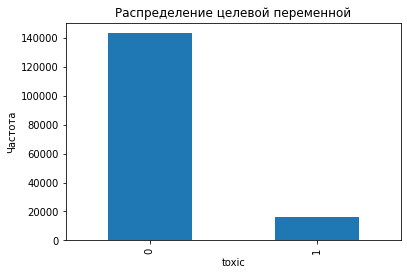

In [6]:
data['toxic'].value_counts().plot(kind='bar', xlabel='toxic', ylabel='Частота', 
                                  title='Распределение целевой переменной');

#### Вывод:
Явно выражен дисбаланс классов

In [7]:
def get_wordnet_pos_bulk(words):
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    pos_tags = nltk.pos_tag(words)
    return [tag_dict.get(tag[1][0].upper(), wordnet.NOUN) for tag in pos_tags]

In [8]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    pos_tags = get_wordnet_pos_bulk(words)
    lemmatized_words = [lemmatizer.lemmatize(word, pos) for word, pos in zip(words, pos_tags)]
    return " ".join(lemmatized_words)

In [9]:
def preprocess_text(text):
    text = contractions.fix(text.lower())
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = " ".join(text.split())
    return text

In [10]:
data['text_clean'] = data['text'].apply(preprocess_text)

In [11]:
data['lemm_text'] = data['text_clean'].apply(lemmatize)

In [12]:
data.head()

,text,toxic,text_clean,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i am s...,d aww he match this background colour i be see...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i am really not trying to edit war it ...,hey man i be really not try to edit war it be ...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i cannot make any real suggestions on imp...,more i can not make any real suggestion on imp...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


## Обучение

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['text', 'toxic', 'text_clean'], axis=1),
                                                    data['toxic'],
                                                    random_state = 42, 
                                                    stratify=data['toxic'])

In [14]:
stopwords = list(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf = count_tf_idf.fit_transform(X_train['lemm_text'])

tf_idf_test = count_tf_idf.transform(X_test['lemm_text'])

In [15]:
pipe_final = Pipeline(
    [
        ('models', LogisticRegression())
    ]
)

In [16]:
param_distributions_lin = [
    {
        'models__C': [10, 12, 14]
    }]

In [17]:
rand = RandomizedSearchCV(
    estimator=pipe_final, 
    param_distributions=param_distributions_lin, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1, 
)

In [18]:
rand.fit(tf_idf, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('models', LogisticRegression())]),
                   n_jobs=-1, param_distributions=[{'models__C': [10, 12, 14]}],
                   scoring='f1')

In [19]:
print(f'Параметры лучшей модели: {rand.best_params_}')
print(f'Метрика f1 для лучшей модели на тренировочной выборке: {round(rand.best_score_, 4)}')

Параметры лучшей модели: {'models__C': 14}
Метрика f1 для лучшей модели на тренировочной выборке: 0.7661


In [20]:
pred = rand.best_estimator_.predict(tf_idf_test)
print(f'Метрика f1 на тестовой выборке: {round(f1_score(y_test, pred), 4)}')

Метрика f1 на тестовой выборке: 0.7732


## Выводы

1. Данные были изучены и подготовлены для обучения. А именно удалены знаки препинания и текст лемматизирован
2. Была обучена модель логистической регрессии. 
3. На модели логистической регрессии удалось достичь значения целевой метрики в 0.766 на тренировочных данных и 0.773 на тестовых

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны